In [4]:
import os
import shutil

def process_pngs(base_path):
    for i in range(100, 200):
        source_path = os.path.join(base_path, f'path{i:03d}')
        target_path = os.path.join(base_path, f'path{i-100:02d}')

        # Check if both source and target directories exist
        if os.path.isdir(source_path) and os.path.isdir(target_path):
            # Get the list of PNG files and sort them to find the last 3
            source_pngs = sorted([f for f in os.listdir(source_path) if f.endswith('.png')])
            target_pngs = sorted([f for f in os.listdir(target_path) if f.endswith('.png')])

            # Copy the last 3 PNGs from source to target
            for png in source_pngs[:8]:
                shutil.copy(os.path.join(source_path, png), os.path.join(target_path, png))
                print(f"Copied {png} from {source_path} to {target_path}")
        else:
            print(f"Directory not found: {source_path} or {target_path}")

# Call the function with the path to your folder
process_pngs('./temp/process/')

Copied panoramic_00.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_01.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_02.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_03.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_04.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_05.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_06.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_07.png from ./temp/process/path100 to ./temp/process/path00
Copied panoramic_00.png from ./temp/process/path101 to ./temp/process/path01
Copied panoramic_01.png from ./temp/process/path101 to ./temp/process/path01
Copied panoramic_02.png from ./temp/process/path101 to ./temp/process/path01
Copied panoramic_03.png from ./temp/process/path101 to ./temp/process/path01
Copied panoramic_04.png from ./temp/process/path101 to ./temp/process/path01

## import

In [1]:
import os
import sys
import time
import re
import numpy as np
import random
from tqdm import tqdm
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import math
import zipfile
import sklearn
import shutil
from glob import glob
from PIL import Image
import tempfile

In [2]:
plt.switch_backend('agg')
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils

## Test Dataset

In [11]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import zipfile
import tempfile
import re
from tqdm import tqdm
from helpers.utils import read_image
import matplotlib.pyplot as plt


def format_name(zip_file_name):
    """
    reads zip file name and format it into lower case
    """
    formatted_name = zip_file_name.lower().replace(".zip", "").split("_")
    return formatted_name

class BldgDataset(Dataset):
    def __init__(
        self,
        data_path="./data/experiments/casestudy.zip",
        mode="train",
        transform=None,
        seq_len=5,
        num_seq=6,
        num_frame=30,
        seed=42,
    ):
        super(BldgDataset, self).__init__()

        self.data_path = data_path
        self.mode = mode
        self.transform = transform
        self.seq_len = seq_len
        self.num_seq = num_seq
        self.building_names = []
        self.num_frame = num_frame  # 30 frames each path

        # Load dataset
        self.data = []
        self.mean = 0.0
        self.std = 0.0
        self.load_dataset()
        self.split_data(seed)

    def load_dataset(self):
        sum_pixels = np.float64(0)
        sum_pixels_squared = np.float64(0)
        pixel_count = np.float64(0)
        # Extract the main zip file if needed
        with zipfile.ZipFile(self.data_path, "r") as main_zip:
            with tempfile.TemporaryDirectory() as temp_dir:
                main_zip.extractall(temp_dir)

                # Iterate over each building sequence label zip file inside the main directory
                for bldg_zip_name in main_zip.namelist():
                    bldg_route_label = format_name(bldg_zip_name)
                    route = bldg_route_label[
                        -1
                    ]  # The last character is the route label a,b,c,d
                    bldg = bldg_route_label[0]
                    sequence_type = " ".join(bldg_route_label[1:-1])
                    if bldg not in self.building_names:
                        self.building_names.append(bldg)

                    # Extract the building sequence label zip file
                    
                    bldg_zip_path = os.path.join(temp_dir, bldg_zip_name)
                    with zipfile.ZipFile(bldg_zip_path, "r") as bldg_zip:
                        bldg_temp_dir = os.path.join(temp_dir, " ".join(bldg_route_label))
                        bldg_zip.extractall(bldg_temp_dir)

                        # Iterate over path folders
                        for path_folder in tqdm(
                            sorted(os.listdir(bldg_temp_dir)),
                            desc=f"Loading {bldg}",
                            unit="path",
                        ):
                            if path_folder.startswith("path"):
                                path_images = []
                                path_folder_full = os.path.join(
                                    bldg_temp_dir, path_folder
                                )

                                for frame in range(
                                    self.num_frame
                                ):  # Assuming 30 frames per path
                                    img_filename = f"panoramic_{frame:02d}.png"
                                    img_path = os.path.join(
                                        path_folder_full, img_filename
                                    )
                                    if os.path.exists(img_path):
                                        img_array = read_image(img_path).astype(
                                            np.float64
                                        )
                                        path_images.append(img_array)
                                        # Update the sums for mean and std calculation
                                        sum_pixels += img_array.sum()
                                        sum_pixels_squared += (img_array**2).sum()
                                        pixel_count += img_array.size

                                # Only consider complete sequences with 30 frames
                                if len(path_images) != self.num_frame:
                                    print(
                                        f"Error: {bldg}, Route {route}, Type{sequence_type},Path {path_folder} does not have 30 images."
                                    )
                                    return
                                else:
                                    self.data.append(
                                        {
                                            "images": np.concatenate(
                                                path_images, axis=0
                                            ),
                                            "path": int(
                                                re.search(r"\d+", path_folder).group()
                                            ),
                                            "route": route,
                                            "bldg": bldg,
                                            "type":sequence_type
                                        }
                                    )
        self.mean = sum_pixels / pixel_count
        variance = (sum_pixels_squared / pixel_count) - (self.mean**2)
        if variance < 0:
            if np.isclose(variance, 0):
                self.std = 0
            else:
                raise ValueError(f"Calculated negative variance: {variance}")
        else:
            self.std = np.sqrt(variance)

    def __getitem__(self, index):
        item = self.data[index]
        imgs = item["images"]
        t_imgs = imgs.reshape(-1, 1, 30, 60)  # num_frame, C, H, W
        # Apply transform if provided
        if self.transform:
            t_imgs = self.transform(t_imgs)
        t_imgs = np.stack(t_imgs, axis=0)
        t_imgs = torch.from_numpy(t_imgs).float()
        # normalize
        t_imgs = (t_imgs - self.mean) / self.std
        (C, H, W) = t_imgs[0].size()
        t_imgs = t_imgs.view(self.num_seq, self.seq_len, C, H, W).transpose(
            1, 2
        )  # num_seq,C,seq_len,H,W

        # Return data as a dictionary
        return {
            "t_imgs": t_imgs,
            "imgs": imgs,
            "path": item["path"],
            "route": item["route"],
            "bldg": item["bldg"],
            "type":item["type"]
        }

    def split_data(self, seed):
        # Split the data into training and validation sets
        np.random.seed(seed)
        np.random.shuffle(self.data)  # Shuffle the data

        split_index = int(len(self.data) * 0.8)
        if self.mode == "train":
            self.data = self.data[:split_index]
        elif self.mode == "val":
            self.data = self.data[split_index:]
        elif self.mode == "predict":
            self.data = self.data [::]

    def __len__(self):
        return len(self.data)

    def find_indices(self, bldg_name, sequence_type,route, path_number):
        """
        Finds the indices of the data items that match the given building, route, and path number.

        :param bldg_name: The name of the building (formatted as 'caracalla baths', for example).
        :param route: The route label (a single character like 'a', 'b', etc.).
        :param path_number: The path number (an integer).
        :return: A list of indices that match the criteria.
        """
        indices = []
        for idx, item in enumerate(self.data):
            if (
                item["bldg"].lower() == bldg_name.lower()
                and item["route"].lower() == route.lower()
                and item["path"] == path_number
                and item["type"] == sequence_type
            ):
                indices.append(idx)
        return indices

    def plot_one_sequence(self, idx):
        """take idx of the data , plot the sequence"""
        path = self[idx]["path"]
        imgs = self[idx]["imgs"]
        bldg = self[idx]["bldg"]
        route = self[idx]["route"]
        sequence_type = self[idx]["type"]
        for img in imgs:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            ax.set_title(f"{bldg} {sequence_type}_route {route}_path {path}")
            plt.imshow(img.reshape(30, 60), cmap="gray", vmin=0, vmax=255)
            plt.show()


In [5]:
# Example of how to use the dataset
dataset = BldgDataset(data_path="./data/experiments/casestudy_1113.zip")
print(dataset.building_names)
print(dataset.mean)
print(dataset.std)

Loading pantheon: 100%|██████████| 200/200 [00:01<00:00, 105.52path/s]


['pantheon', 'trajan', 'caracalla', 'iim']
91.09665949652778
89.93876027597848


In [7]:
print(dataset[0].keys(
))
print(dataset[0]['type'])

dict_keys(['t_imgs', 'imgs', 'path', 'route', 'bldg', 'type'])
exterior walkway


In [8]:
print(dataset[0]["imgs"].shape)
print(dataset[0]["t_imgs"].shape)
print(dataset[0]["bldg"])

(30, 30, 60)
torch.Size([6, 1, 5, 30, 60])
iim


### Examine the dataset

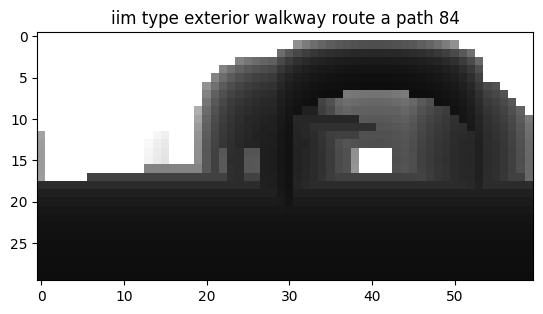

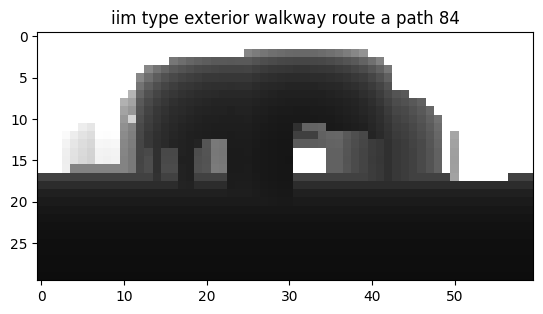

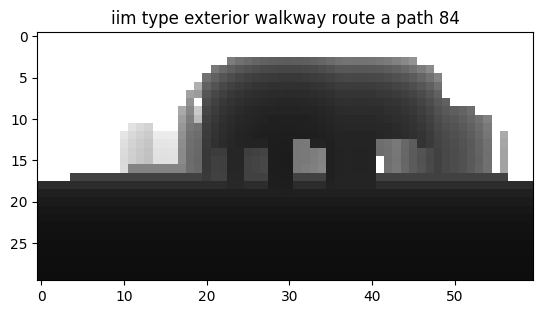

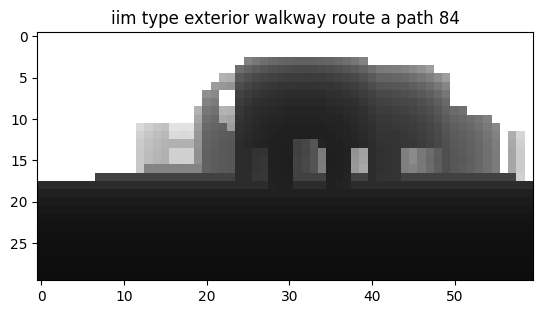

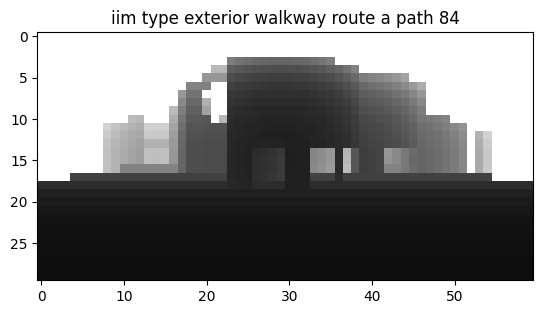

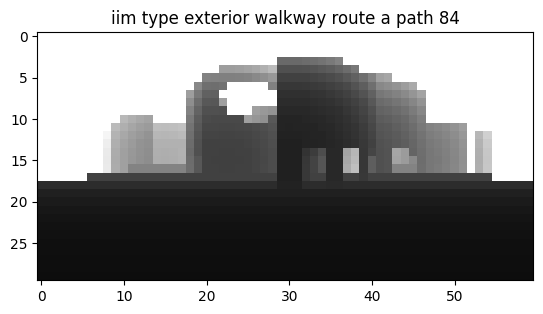

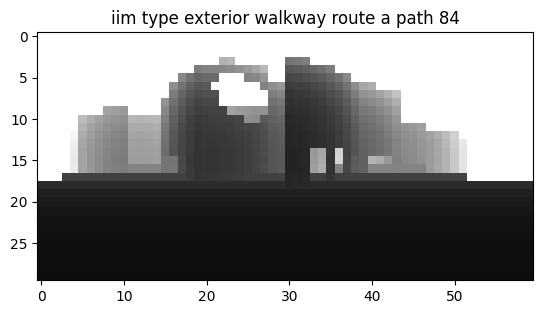

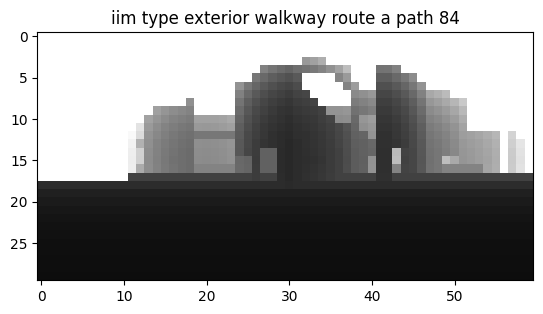

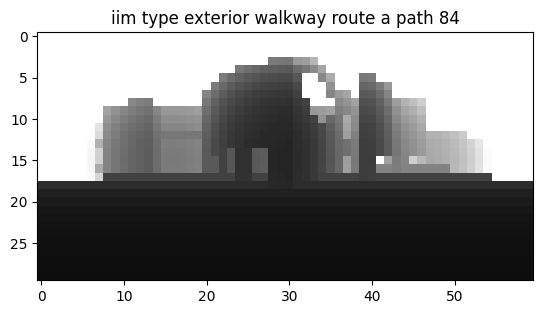

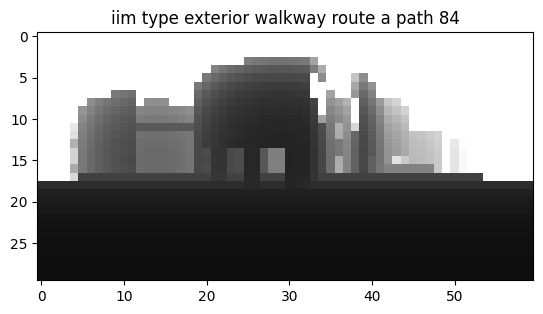

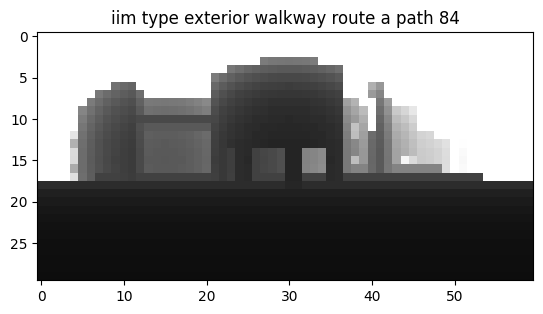

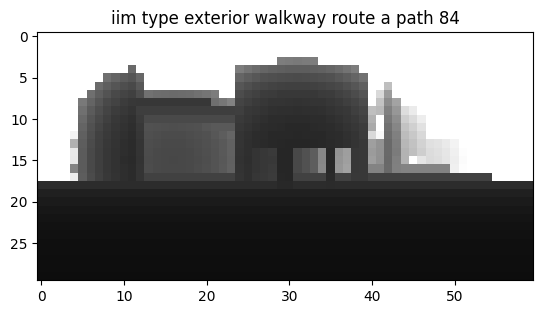

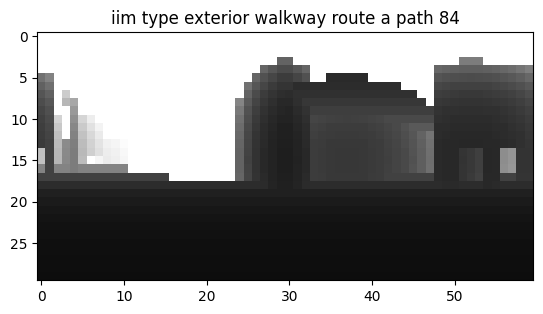

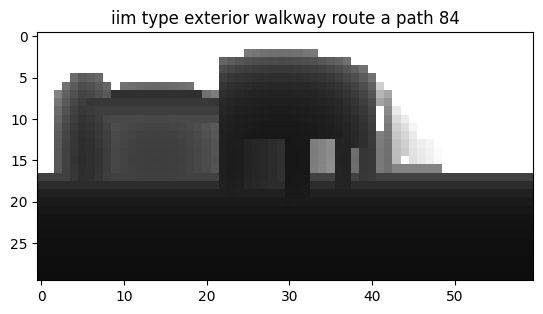

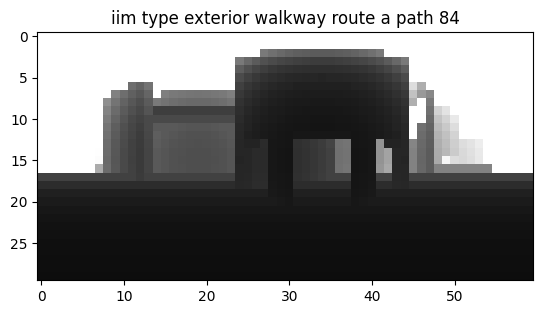

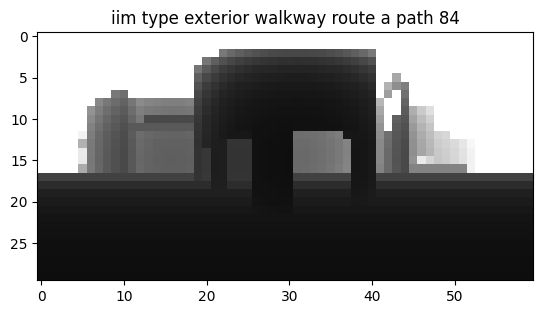

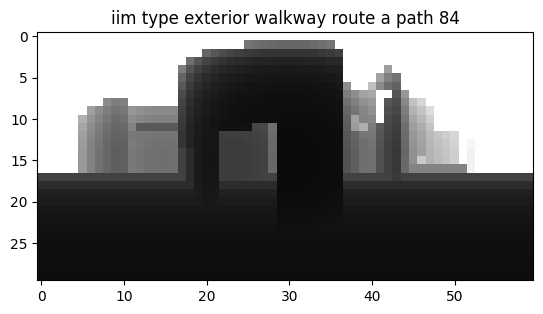

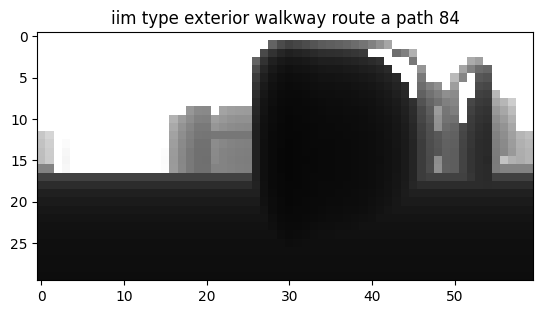

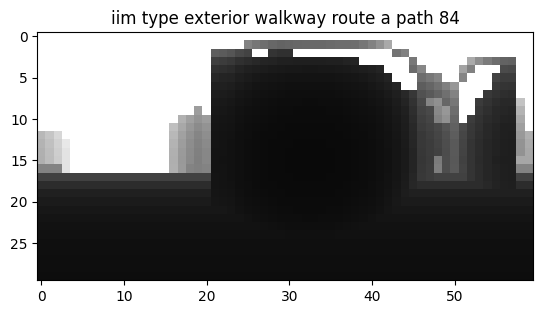

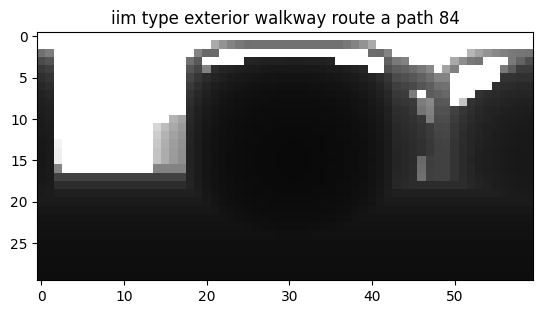

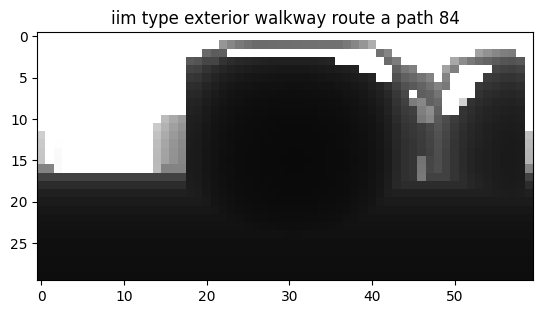

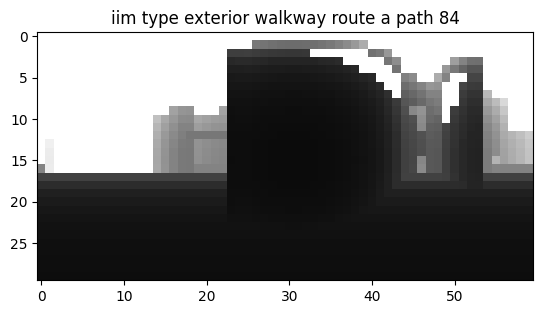

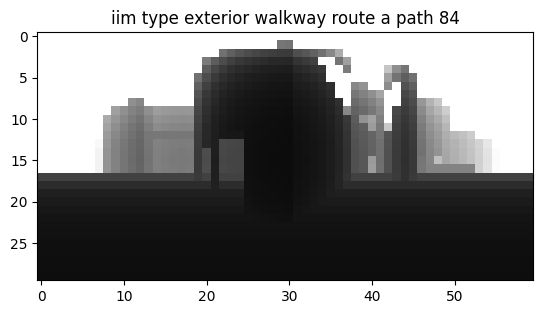

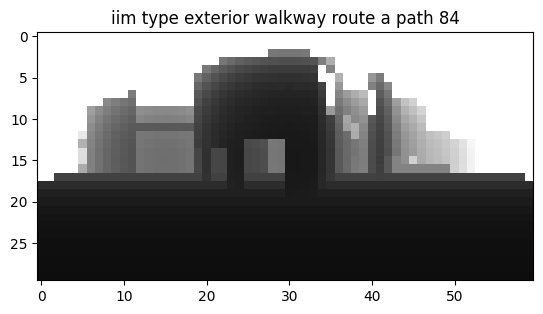

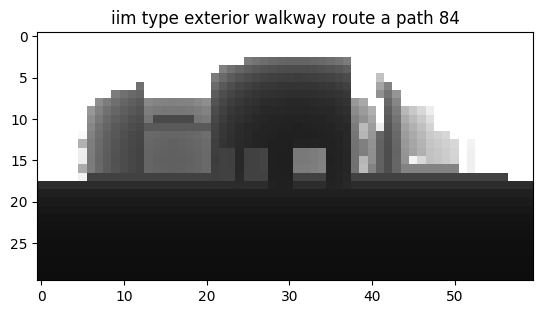

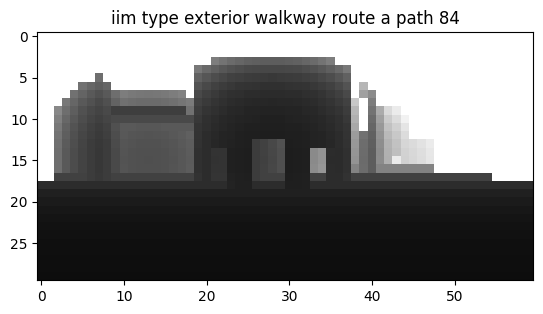

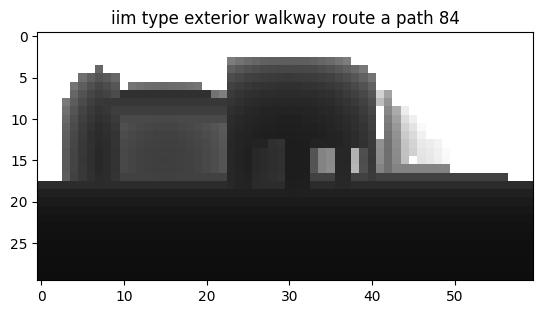

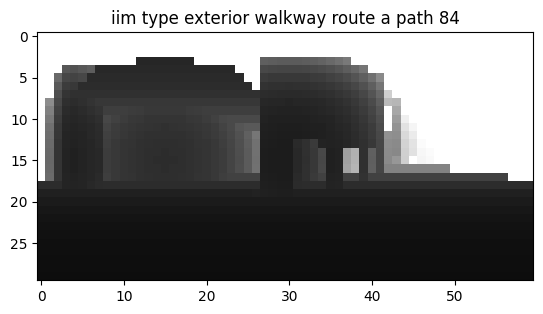

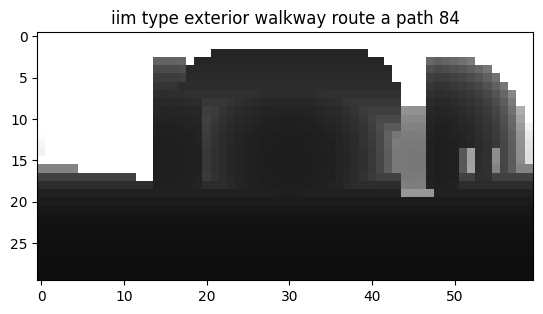

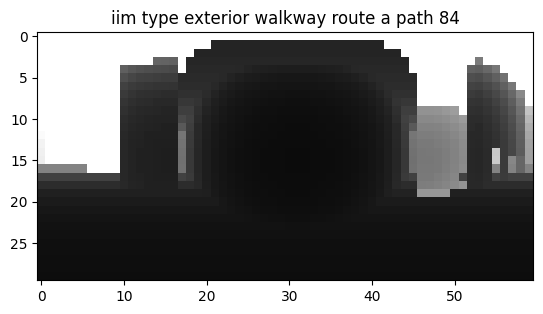

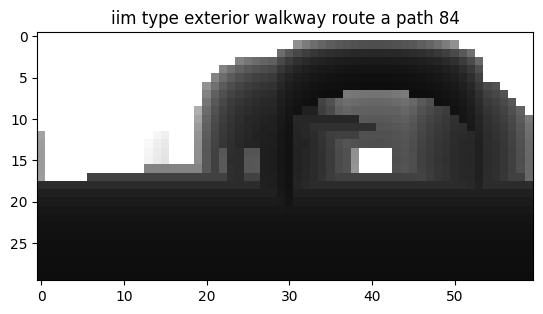

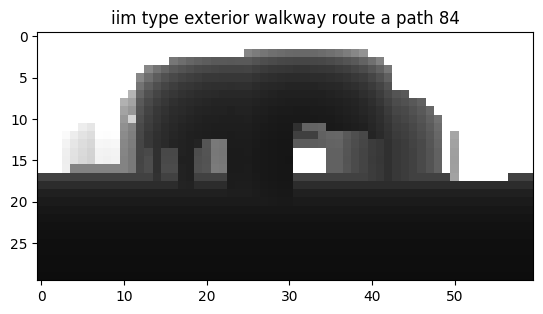

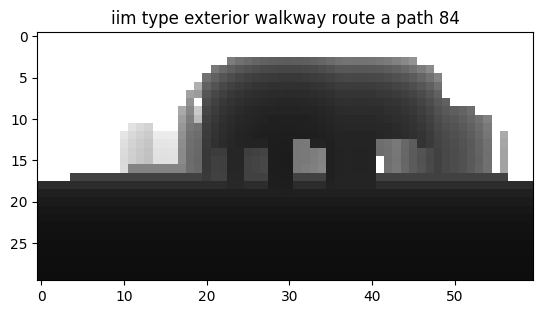

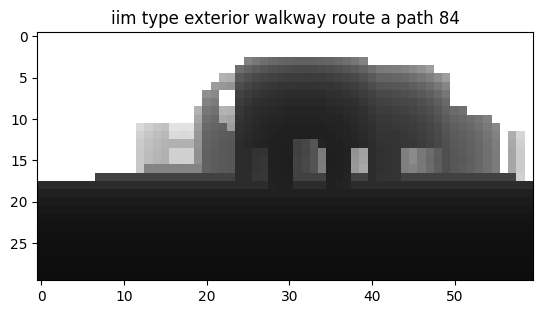

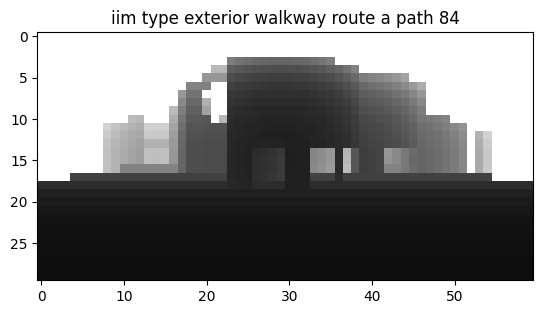

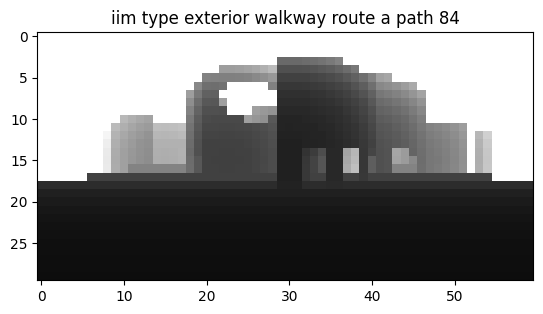

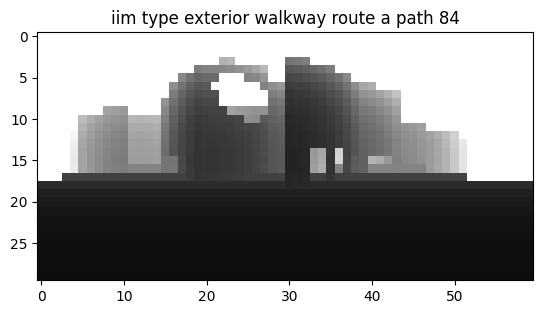

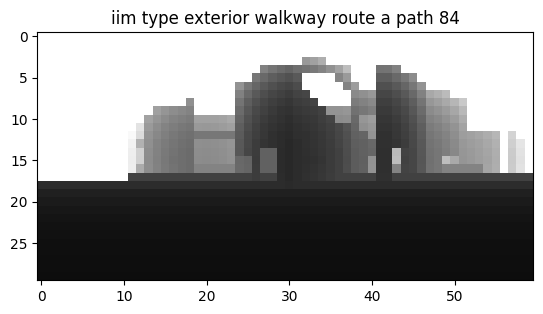

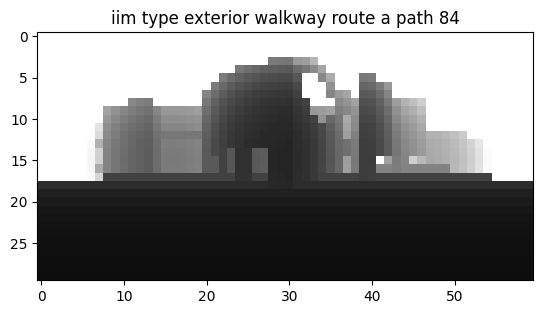

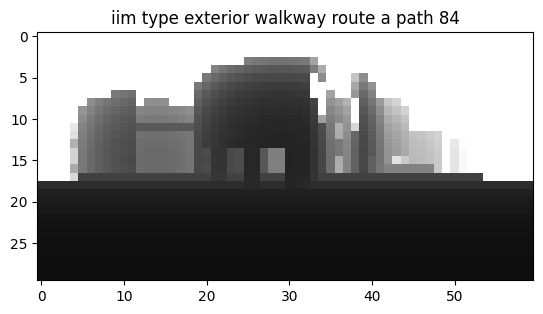

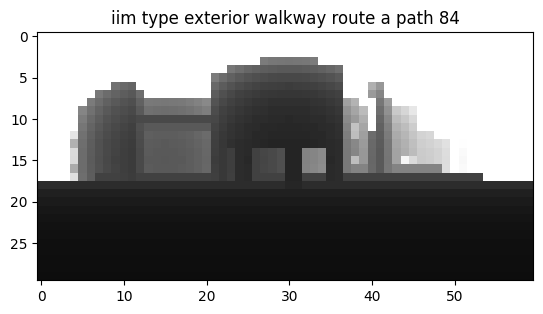

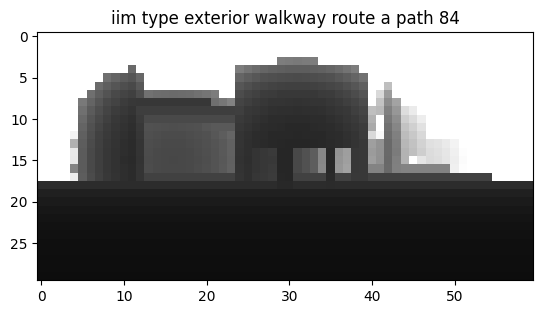

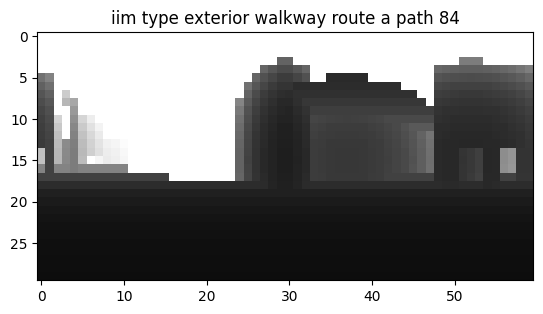

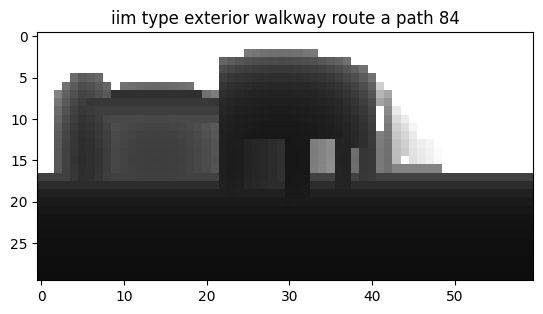

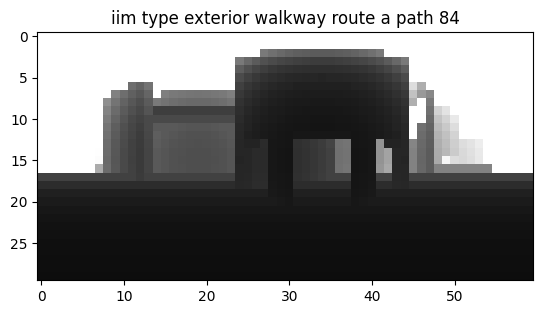

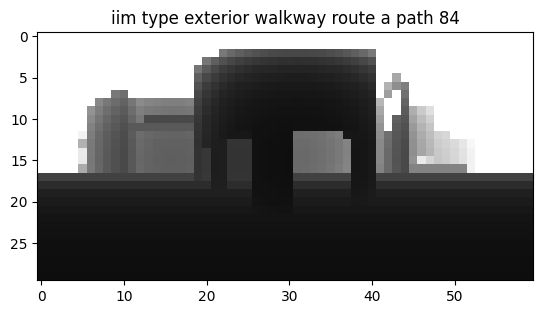

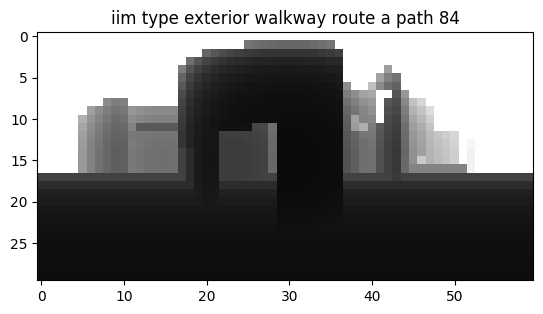

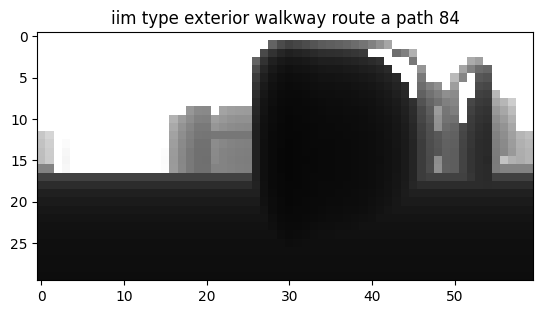

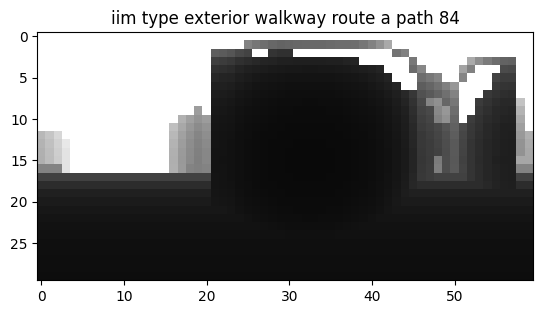

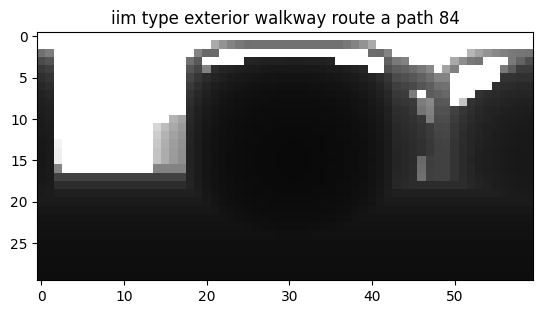

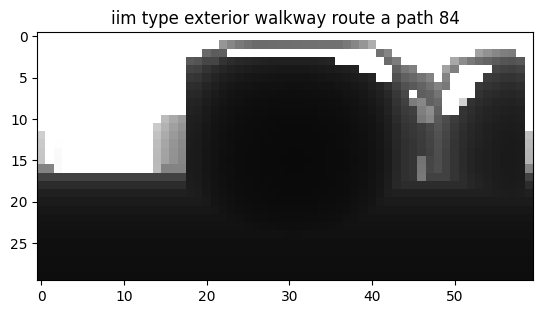

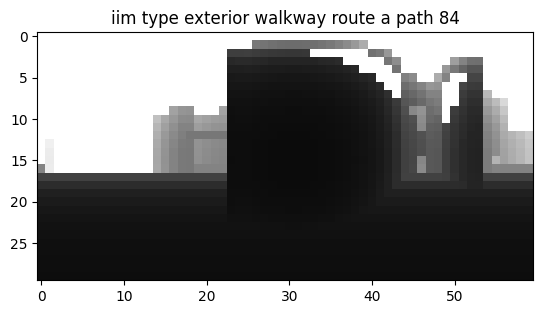

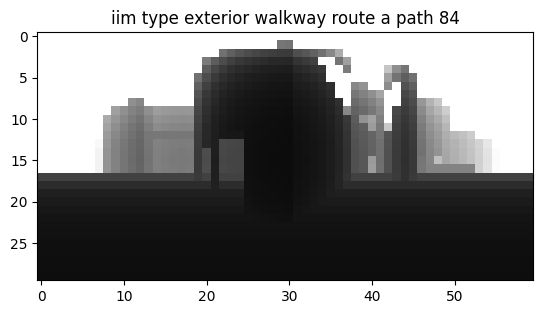

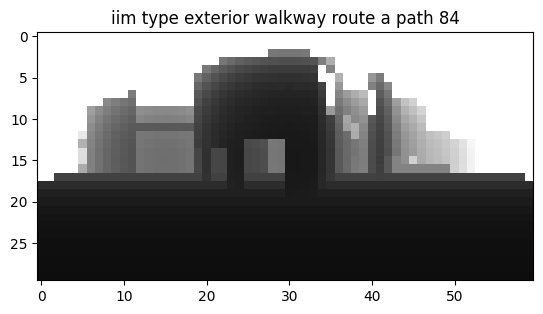

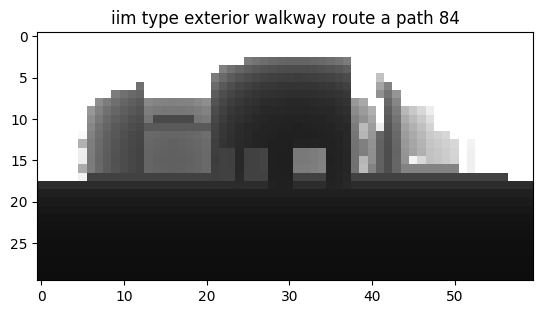

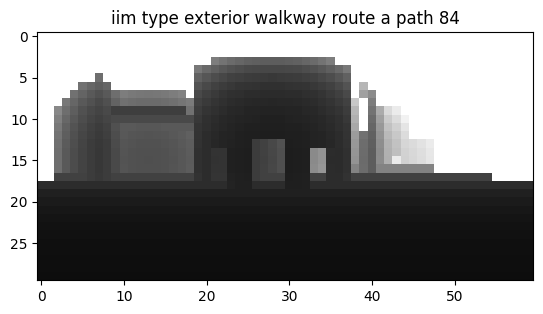

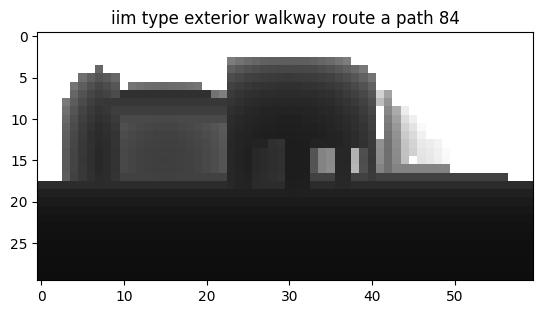

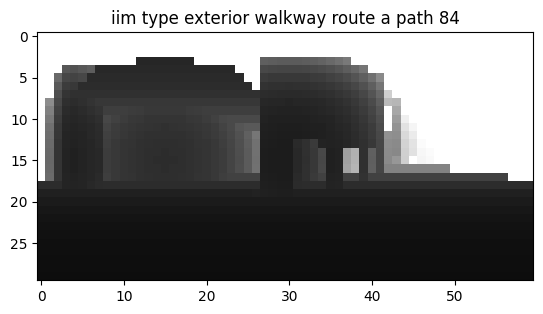

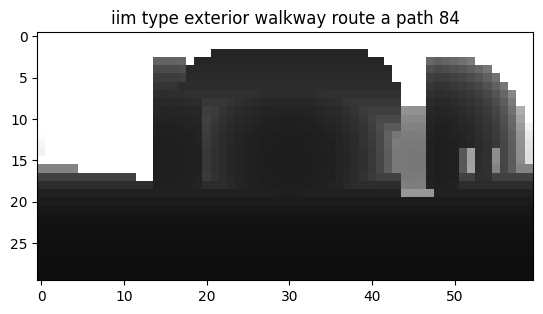

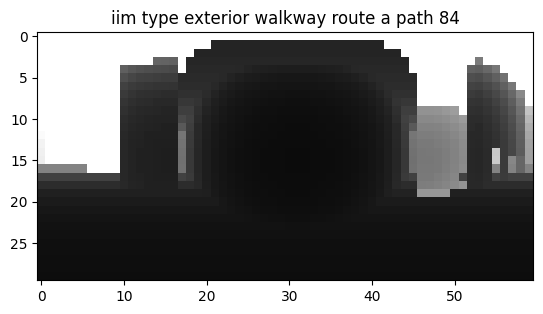

In [10]:
%matplotlib inline
dataset.plot_one_sequence(0)

# Test Image Augmentation

In [ ]:
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
import numbers
from PIL import Image

In [ ]:
class BrightnessJitter(object):  # 0.5 to 5 is a good range
    def __init__(self, brightness=0, consistent=True, p=0.5):
        self.brightness = self._check_input(brightness, "brightness")
        self.consistent = consistent
        self.threshold = p

    def _check_input(
        self, value, name, center=1, bound=(0, float("inf")), clip_first_on_zero=True
    ):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError(
                    "If {} is a single number, it must be non negative.".format(name)
                )
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError(
                "{} should be a single number or a list/tuple with lenght 2.".format(
                    name
                )
            )

        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness):
        transforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            transforms.append(lambda img: img * brightness_factor)

        transform = torchvision.transforms.Compose(transforms)

        return transform

    def __call__(self, imgmap):
        if random.random() < self.threshold:  # do BrightnessJitter
            if self.consistent:
                transform = self.get_params(self.brightness)
                return [transform(i) for i in imgmap]
            else:
                result = []
                for img in imgmap:
                    transform = self.get_params(self.brightness)
                    result.append(transform(img))
                return result
        else:  # don't do BrightnessJitter, do nothing
            return imgmap

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += "brightness={0}".format(self.brightness)
        format_string += ")"
        return format_string

In [ ]:
# need to test
class RandomHorizontalShift:
    def __init__(self, max_shift=30, p=0.5):
        """
        Args:
            max_shift (int): the maximum number of pixels for the horizontal shift.
            p (float): probability of applying the shift. Default is 0.5.
        """
        self.max_shift = max_shift
        self.p = p

    def __call__(self, imgmap):
        return [self.horizontal_shift(img) for img in imgmap]

    def horizontal_shift(self, img):
        """
        Shift the image horizontally by a random number of pixels and wrap around.
        Args:
            img (ndarray): the input image as a numpy array.
        Returns:
            img (ndarray): the transformed image as a numpy array.
        """
        # Check if we should apply the shift based on the probability p
        if random.random() < self.p:
            shift = random.randint(0, self.max_shift)
            shifted_np_img = np.roll(img, shift, axis=2)  # roll along width dimension
            return shifted_np_img
        return img  # return original image if not shifted

In [ ]:
class RandomHorizontalFlip:  # choose consistent to be false
    def __init__(self, consistent=True, p=0.5):
        self.consistent = consistent
        self.threshold = p

    def __call__(self, imgmap):
        if self.consistent:
            if random.random() > self.threshold:
                return [np.flip(i, axis=[0, 2]) for i in imgmap]
            else:
                return imgmap
        else:
            result = []
            for i in imgmap:
                if random.random() > self.threshold:
                    result.append(np.flip(i, axis=[0, 2]))
                else:
                    result.append(i)
            assert len(result) == len(imgmap)
            return result

## Test Of Image Augmentation

In [ ]:
test_dataset = dataset[0]["imgs"][:10]
brightness_jitter_transform = BrightnessJitter(
    brightness=[0.5, 5], consistent=False, p=1
)
brightness_jittered_dataset = brightness_jitter_transform(test_dataset)
print(len(brightness_jittered_dataset[0]))

for i in range(len(test_dataset)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = brightness_jittered_dataset[i]
    ax.set_title(f"img {i}")
    ax.imshow(img.reshape(30, 60), cmap="gray", vmin=0, vmax=255)
    plt.show()

In [ ]:
test_dataset = test_dataset.reshape(-1, 1, 30, 60)
horizontal_shift_transform = RandomHorizontalShift(max_shift=60)
shifted_dataset = horizontal_shift_transform(test_dataset)

for i in range(len(test_dataset)):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    img = shifted_dataset[i]
    ax.set_title(f"Img {i}")
    ax.imshow(img.reshape(30, 60), cmap="gray", vmin=0, vmax=255)
    plt.show()

In [ ]:
horizontal_flip_transform = RandomHorizontalFlip(consistent=os.truncate, p=0.5)
flipped_dataset = horizontal_flip_transform(test_dataset)

for i in range(len(test_dataset)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    origin = test_dataset[i]
    flipped = flipped_dataset[i]

    axes[0].set_title("Original")
    axes[0].imshow(origin.reshape(30, 60), cmap="gray", vmin=0, vmax=255)

    axes[1].set_title("Flipped")
    axes[1].imshow(flipped.reshape(30, 60), cmap="gray", vmin=0, vmax=255)

    plt.show()

In [ ]:
train_transform = transforms.Compose(
    [
        RandomHorizontalFlip(consistent=True, p=0.5),
        BrightnessJitter(brightness=[0.5, 5], consistent=True, p=0.5),
        RandomHorizontalShift(max_shift=60, p=0.5),
    ]
)
test_transform = BldgDataset(transform=train_transform)

In [ ]:
test_transform[5]["t_imgs"].mean()

# Hyperparameters and Utils

In [ ]:
from helpers.utils import (
    AverageMeter,
    save_checkpoint,
    Logger,
    neq_load_customized,
    MultiStepLR_Restart_Multiplier,
    calc_topk_accuracy,
)

In [ ]:
args = {
    "net": "resnet18",
    "model": "memdpc",
    "dataset": "BldgDataset",
    "seq_len": 5,  # to 5
    "num_seq": 6,  # to 6
    "pred_step": 3,  # to 2
    "ds": 3,
    "mem_size": 512,  # 1024
    "batch_size": 8,  # 4
    "lr": 1e-3,
    "wd": 1e-5,
    "resume": "",
    "pretrain": "",
    "epochs": 500,
    "start_epoch": 0,
    "gpu": "0,1",
    "print_freq": 5,
    "reset_lr": False,
    "prefix": "tmp",
    "img_dim": [30, 60],  # need to change to [30,60]
    "seed": 0,
    "workers": 16,
    "p": 0.8,  # probability to apply data augmentation
}

# Model

In [ ]:
from backbone.select_backbone import select_resnet
from backbone.convrnn import ConvGRU
import torch.nn.functional as F

In [ ]:
# test shape
from backbone.resnet_2d3d import resnet18_2d3d_full

resModel = resnet18_2d3d_full()
print(resModel)

In [ ]:
# x: video input, size = [BatchSize,Channel,TimeSteps,Height,Width],
# e.g. [16*6,1,5,30,60]
test_tensor = torch.randn(96, 1, 5, 30, 60)
output = resModel(test_tensor)
# Print the output size
print(output.size())

In [ ]:
print([int(math.ceil(x / 32)) for x in [30, 60]])

In [ ]:
class MemDPC_BD(nn.Module):
    """MemDPC with bi-directional RNN"""

    def __init__(
        self,
        sample_size=[30, 60],
        num_seq=8,
        seq_len=5,
        pred_step=3,
        network="resnet18",
        mem_size=1024,
    ):
        super(MemDPC_BD, self).__init__()
        print(
            "Using MemDPC-BiDirectional model with {} and mem_size {}".format(
                network, mem_size
            )
        )
        self.sample_size = sample_size
        self.num_seq = num_seq
        self.seq_len = seq_len
        self.pred_step = pred_step
        self.last_duration = int(math.ceil(seq_len / 4))
        self.last_size = [int(math.ceil(x / 32)) for x in sample_size]
        self.mem_size = mem_size
        self.tgt_dict = {}
        print(
            "final feature map has size %dx%d" % (self.last_size[0], self.last_size[1])
        )

        self.backbone, self.param = select_resnet(
            network
        )  # param come from this function
        self.param["num_layers"] = 1  # param for GRU
        self.param["hidden_size"] = self.param["feature_size"]  # param for GRU
        self.param["membanks_size"] = mem_size
        self.mb = torch.nn.Parameter(
            torch.randn(self.param["membanks_size"], self.param["feature_size"])
        )
        print(
            "MEM Bank has size %dx%d"
            % (self.param["membanks_size"], self.param["feature_size"])
        )

        # bi-directional RNN
        self.agg_f = ConvGRU(
            input_size=self.param["feature_size"],
            hidden_size=self.param["hidden_size"],
            kernel_size=1,
            num_layers=self.param["num_layers"],
        )
        self.agg_b = ConvGRU(
            input_size=self.param["feature_size"],
            hidden_size=self.param["hidden_size"],
            kernel_size=1,
            num_layers=self.param["num_layers"],
        )

        self.network_pred = nn.Sequential(
            nn.Conv2d(
                self.param["feature_size"],
                self.param["feature_size"],
                kernel_size=1,
                padding=0,
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                self.param["feature_size"],
                self.param["membanks_size"],
                kernel_size=1,
                padding=0,
            ),
        )
        self.mask = None
        self.relu = nn.ReLU(inplace=False)
        self.ce_loss = nn.CrossEntropyLoss(reduction="none")

        self._initialize_weights(self.agg_f)
        self._initialize_weights(self.agg_b)
        self._initialize_weights(self.network_pred)

    def get_loss(self, pred, gt, B, SL, last_size, feature_size, kernel=1):
        # pred: B,C,N,H,W
        # GT: C,B,N,H*H
        score = torch.matmul(
            pred.permute(0, 2, 3, 4, 1)
            .contiguous()
            .view(B * SL * last_size[0] * last_size[1], feature_size),
            gt.contiguous().view(feature_size, B * SL * last_size[0] * last_size[1]),
        )
        if SL not in self.tgt_dict:
            self.tgt_dict[SL] = torch.arange(B * SL * last_size[0] * last_size[1])
        tgt = self.tgt_dict[SL].to(score.device)
        loss = self.ce_loss(score, tgt)
        top1, top5 = calc_topk_accuracy(score, tgt, (1, 5))
        return loss, top1, top5

    def forward(self, block):  # input_seq
        # extract feature
        (
            B,
            N,
            C,
            SL,
            H,
            W,
        ) = (
            block.shape
        )  # batch size, blocks?, channel, number of steps(consecutive frames used for prediction), H,W
        block = block.view(B * N, C, SL, H, W)
        feat3d = self.backbone(block)  # put into resNet to extract features

        feat3d = F.avg_pool3d(feat3d, (self.last_duration, 1, 1), stride=(1, 1, 1))
        feat3d = feat3d.view(
            B, N, self.param["feature_size"], self.last_size[0], self.last_size[1]
        )  # before ReLU, (-inf, +inf)

        losses = []  # all loss
        acc = []  # all acc
        loss = 0
        gt = (
            feat3d.permute(2, 0, 1, 3, 4)
            .contiguous()
            .view(
                self.param["feature_size"], B, N, self.last_size[0] * self.last_size[1]
            )
        )

        feat3d_b = torch.flip(feat3d, dims=(1,))
        gt_b = torch.flip(gt, dims=(2,))

        # forward MemDPC
        pd_tmp_pool = []
        for j in range(self.pred_step):
            if j == 0:
                feat_tmp = feat3d[:, 0 : (N - self.pred_step), :, :, :]
                _, hidden = self.agg_f(F.relu(feat_tmp))
                context_feature = hidden.clone()
            else:
                _, hidden = self.agg_f(F.relu(pd_tmp).unsqueeze(1), hidden.unsqueeze(0))
            hidden = hidden[
                :, -1, :
            ]  # after tanh, (-1,1). get the hidden state of last layer, last time step
            pd_tmp = self.network_pred(hidden)
            pd_tmp = F.softmax(pd_tmp, dim=1)  # B,MEM,H,W
            pd_tmp = torch.einsum("bmhw,mc->bchw", pd_tmp, self.mb)
            pd_tmp_pool.append(pd_tmp)

        pd_tmp_pool = torch.stack(pd_tmp_pool, dim=2)
        SL_tmp = pd_tmp_pool.size(2)
        gt_tmp = gt[:, :, -self.pred_step : :, :]
        loss_tmp, top1, top5 = self.get_loss(
            pd_tmp_pool, gt_tmp, B, SL_tmp, self.last_size, self.param["feature_size"]
        )
        loss_tmp = loss_tmp.mean()
        loss = loss_tmp
        losses.append(loss_tmp.data.unsqueeze(0))
        acc.append(torch.stack([top1, top5], 0).unsqueeze(0))

        # backward MemDPC
        pd_tmp_pool_b = []
        for j in range(self.pred_step):
            if j == 0:
                feat_tmp = feat3d_b[:, 0 : (N - self.pred_step), :, :, :]
                _, hidden = self.agg_b(F.relu(feat_tmp))
            else:
                _, hidden = self.agg_b(
                    F.relu(pd_tmp_b).unsqueeze(1), hidden.unsqueeze(0)
                )
            hidden = hidden[
                :, -1, :
            ]  # after tanh, (-1,1). get the hidden state of last layer, last time step
            pd_tmp_b = self.network_pred(hidden)
            pd_tmp_b = F.softmax(pd_tmp_b, dim=1)  # B,MEM,H,W
            pd_tmp_b = torch.einsum("bmhw,mc->bchw", pd_tmp_b, self.mb)
            pd_tmp_pool_b.append(pd_tmp_b)

        pd_tmp_pool_b = torch.stack(pd_tmp_pool_b, dim=2)
        SL_tmp = pd_tmp_pool_b.size(2)
        gt_tmp_b = gt_b[:, :, -self.pred_step : :, :]
        loss_tmp_b, top1, top5 = self.get_loss(
            pd_tmp_pool_b,
            gt_tmp_b,
            B,
            SL_tmp,
            self.last_size,
            self.param["feature_size"],
        )
        loss_tmp_b = loss_tmp_b.mean()
        losses.append(loss_tmp_b.data.unsqueeze(0))
        acc.append(torch.stack([top1, top5], 0).unsqueeze(0))

        loss = loss + loss_tmp_b

        return loss, losses, acc, context_feature

    def extract_features(self, block):
        (B, N, C, SL, H, W) = block.shape
        block = block.view(B * N, C, SL, H, W)
        feat3d = self.backbone(block)
        feat3d = F.avg_pool3d(feat3d, (self.last_duration, 1, 1), stride=(1, 1, 1))
        feat3d = feat3d.view(
            B, N, self.param["feature_size"], self.last_size[0], self.last_size[1]
        )

        feat_tmp = feat3d[:, 0 : (N - self.pred_step), :, :, :]
        _, hidden = self.agg_f(F.relu(feat_tmp))
        context_feature = hidden.clone()

        return context_feature

    def _initialize_weights(self, module):
        for name, param in module.named_parameters():
            if "bias" in name:
                nn.init.constant_(param, 0.0)
            elif "weight" in name:
                nn.init.orthogonal_(param, 0.1)

# Data Loader

In [ ]:
from sklearn.model_selection import train_test_split


def get_data(transform, args=args, mode="train"):
    print("Loading {} dataset for {}".format(args["dataset"], mode))

    dataset = BldgDataset(
        mode=mode,
        transform=transform,
        seq_len=args["seq_len"],
        num_seq=args["num_seq"],
    )

    shuffle = mode == "train"
    if shuffle:
        sampler = data.RandomSampler(dataset)
    else:
        sampler = None

    data_loader = data.DataLoader(
        dataset,
        batch_size=args["batch_size"],
        sampler=sampler,
        shuffle=shuffle
        and sampler
        is None,  # Only shuffle if training and no other sampler is specified
        num_workers=args["workers"],
        pin_memory=True,
        drop_last=True,  # Typically for ensuring consistent batch sizes, especially during training
    )

    print('"{}" dataset size: {}'.format(mode, len(dataset)))
    return data_loader

## Set Path

In [ ]:
def set_path(args):
    if args["resume"]:
        exp_path = os.path.dirname(os.path.dirname(args["resume"]))
    else:
        exp_path = (
            f"log_{args['prefix']}/{args['model']}_{args['dataset']}-{args['img_dim'][0]}_{args['img_dim'][1]}_{args['net']}_"
            f"mem{args['mem_size']}_bs{args['batch_size']}_lr{args['lr']}_seq{args['num_seq']}_pred{args['pred_step']}_"
            f"len{args['seq_len']}_ds{args['ds']}"
        )

    img_path = os.path.join(exp_path, "img")
    model_path = os.path.join(exp_path, "model")
    if not os.path.exists(img_path):
        os.makedirs(img_path)
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    return img_path, model_path

## Train one epoch

In [ ]:
def train_one_epoch(
    data_loader, model, criterion, optimizer, lr_scheduler, device, epoch, args
):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracy = [
        [AverageMeter(), AverageMeter()],  # forward top1, top5
        [AverageMeter(), AverageMeter()],
    ]  # backward top1, top5

    model.train()
    end = time.time()
    tic = time.time()

    for idx, input_seq in enumerate(data_loader):
        # print('inside the data_loader loop now')
        data_time.update(time.time() - end)

        input_seq = input_seq.to(device)

        B = input_seq["t_imgs"].size(0)
        loss, loss_step, acc, extra = model(input_seq["t_imgs"])

        for i in range(2):
            top1, top5 = acc[i].mean(0)  # average acc across multi-gpus
            accuracy[i][0].update(top1.item(), B)
            accuracy[i][1].update(top5.item(), B)

        loss = loss.mean()  # average loss across multi-gpus
        losses.update(loss.item(), B)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        if idx % args["print_freq"] == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Loss {loss.val:.6f}\t"
                "Acc: {acc[0][0].val:.4f}\t"
                "T-data:{dt.val:.2f} T-batch:{bt.val:.2f}\t".format(
                    epoch,
                    idx,
                    len(data_loader),
                    loss=losses,
                    acc=accuracy,
                    dt=data_time,
                    bt=batch_time,
                )
            )

            args["writer_train"].add_scalar("local/loss", losses.val, args["iteration"])
            args["writer_train"].add_scalar(
                "local/F-top1", accuracy[0][0].val, args["iteration"]
            )
            args["writer_train"].add_scalar(
                "local/F-top5", accuracy[0][1].val, args["iteration"]
            )
            args["writer_train"].add_scalar(
                "local/B-top1", accuracy[1][0].val, args["iteration"]
            )
            args["writer_train"].add_scalar(
                "local/B-top5", accuracy[1][1].val, args["iteration"]
            )

        args["iteration"] += 1
        if lr_scheduler is not None:
            lr_scheduler.step()

    print("Epoch: [{0}]\t" "T-epoch:{t:.2f}\t".format(epoch, t=time.time() - tic))

    args["writer_train"].add_scalar("global/loss", losses.avg, epoch)
    args["writer_train"].add_scalar("global/F-top1", accuracy[0][0].avg, epoch)
    args["writer_train"].add_scalar("global/F-top5", accuracy[0][1].avg, epoch)
    args["writer_train"].add_scalar("global/B-top1", accuracy[1][0].avg, epoch)
    args["writer_train"].add_scalar("global/B-top5", accuracy[1][1].avg, epoch)

    return losses.avg, np.mean([accuracy[0][0].avg, accuracy[1][0].avg])

## Validation

In [ ]:
def validate(data_loader, model, criterion, device, epoch, args):
    losses = AverageMeter()
    accuracy = [
        [AverageMeter(), AverageMeter()],  # forward top1, top5
        [AverageMeter(), AverageMeter()],
    ]  # backward top1, top5

    model.eval()

    with torch.no_grad():
        for idx, input_seq in enumerate(data_loader):
            input_seq = input_seq.to(device)
            B = input_seq["t_imgs"].size(0)
            loss, loss_step, acc, extra = model(input_seq["t_imgs"])

            for i in range(2):
                top1, top5 = acc[i].mean(0)  # average acc across multi-gpus
                accuracy[i][0].update(top1.item(), B)
                accuracy[i][1].update(top5.item(), B)

            loss = loss.mean()  # average loss across multi-gpus
            losses.update(loss.item(), B)

    print(
        "Epoch: [{0}/{1}]\t"
        "Loss {loss.val:.6f}\t"
        "Acc: {acc[0][0].val:.4f}\t".format(
            epoch, args["epochs"], loss=losses, acc=accuracy
        )
    )

    args["writer_val"].add_scalar("global/loss", losses.avg, epoch)
    args["writer_val"].add_scalar("global/F-top1", accuracy[0][0].avg, epoch)
    args["writer_val"].add_scalar("global/F-top5", accuracy[0][1].avg, epoch)
    args["writer_val"].add_scalar("global/B-top1", accuracy[1][0].avg, epoch)
    args["writer_val"].add_scalar("global/B-top5", accuracy[1][1].avg, epoch)

    return losses.avg, np.mean([accuracy[0][0].avg, accuracy[1][0].avg])

# Main

In [ ]:
def main(args):
    torch.manual_seed(args["seed"])
    np.random.seed(args["seed"])
    random.seed(args["seed"])

    os.environ["CUDA_VISIBLE_DEVICES"] = str(args["gpu"])
    device = torch.device("cuda")
    num_gpu = len(str(args["gpu"]).split(","))
    args["batch_size"] = num_gpu * args["batch_size"]

    ### model ###
    # need to test:
    # num_seq to 10?  seq_len to 3
    if args["model"] == "memdpc":
        model = MemDPC_BD(
            sample_size=args["img_dim"],
            num_seq=args["num_seq"],
            seq_len=args["seq_len"],
            network=args["net"],
            pred_step=args["pred_step"],
            mem_size=args["mem_size"],
        )
    else:
        raise NotImplementedError("wrong model!")

    model.to(device)
    model = nn.DataParallel(model)
    model_without_dp = model.module

    ### optimizer ###
    params = model.parameters()
    optimizer = optim.Adam(params, lr=args["lr"], weight_decay=args["wd"])
    criterion = nn.CrossEntropyLoss()

    ### data ###
    train_transform = transforms.Compose(
        [
            RandomHorizontalFlip(consistent=True, p=args["p"]),
            BrightnessJitter(brightness=[0.5, 5], consistent=True, p=args["p"]),
            RandomHorizontalShift(max_shift=60, p=args["p"]),
        ]
    )

    val_transform = None

    train_loader = get_data(train_transform, args=args, mode="train")
    val_loader = get_data(val_transform, args=args, mode="val")

    lr_milestones_eps = [50, 100]  # can be smaller

    lr_milestones = [len(train_loader) * m for m in lr_milestones_eps]
    print(
        "=> Use lr_scheduler: %s eps == %s iters"
        % (str(lr_milestones_eps), str(lr_milestones))
    )
    lr_lambda = lambda ep: MultiStepLR_Restart_Multiplier(
        ep, gamma=0.1, step=lr_milestones, repeat=1
    )
    lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    best_acc = 0
    args["iteration"] = 1

    ### restart training ###
    if args["resume"]:
        if os.path.isfile(args["resume"]):
            print("=> loading resumed checkpoint '{}'".format(args["resume"]))
            checkpoint = torch.load(args["resume"], map_location=torch.device("cpu"))
            args["start_epoch"] = checkpoint["epoch"]
            args["iteration"] = checkpoint["iteration"]
            best_acc = checkpoint["best_acc"]
            model_without_dp.load_state_dict(checkpoint["state_dict"])
            try:
                optimizer.load_state_dict(checkpoint["optimizer"])
            except:
                print("[WARNING] Not loading optimizer states")
            print(
                "=> loaded resumed checkpoint '{}' (epoch {})".format(
                    args["resume"], checkpoint["epoch"]
                )
            )
        else:
            print("[Warning] no checkpoint found at '{}'".format(args["resume"]))
            sys.exit(0)

    # logging tools
    args["img_path"], args["model_path"] = set_path(args)
    args["logger"] = Logger(path=args["img_path"])
    args["logger"].log(
        "args=\n\t\t"
        + "\n\t\t".join(["%s:%s" % (str(k), str(v)) for k, v in args.items()])
    )

    args["writer_val"] = SummaryWriter(logdir=os.path.join(args["img_path"], "val"))
    args["writer_train"] = SummaryWriter(logdir=os.path.join(args["img_path"], "train"))

    torch.backends.cudnn.benchmark = True

    ### main loop ###
    for epoch in range(args["start_epoch"], args["epochs"]):
        np.random.seed(epoch)
        random.seed(epoch)

        train_loss, train_acc = train_one_epoch(
            train_loader, model, criterion, optimizer, lr_scheduler, device, epoch, args
        )
        val_loss, val_acc = validate(val_loader, model, criterion, device, epoch, args)

        # save check_point
        is_best = val_acc > best_acc
        best_acc = max(val_acc, best_acc)
        save_dict = {
            "epoch": epoch,
            "state_dict": model_without_dp.state_dict(),
            "best_acc": best_acc,
            "optimizer": optimizer.state_dict(),
            "iteration": args["iteration"],
        }
        save_checkpoint(
            save_dict,
            is_best,
            filename=os.path.join(args["model_path"], "epoch%s.pth.tar" % str(epoch)),
            keep_all=False,
        )

    print(
        "Training from ep %d to ep %d finished" % (args["start_epoch"], args["epochs"])
    )
    # sys.exit(0)

# Train

In [ ]:
def change_args(args, mem_size=512, epochs=250, batch_size=4, p=0.5, lr=5e-3, wd=1e-4):
    args["mem_size"] = mem_size
    args["epochs"] = epochs
    args["workers"] = 12
    args["batch_size"] = batch_size
    args["p"] = p
    args["lr"] = lr
    args["wd"] = wd
    return args

In [ ]:
change_args(args)
main(args)